In [84]:
import re

import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib

import sys
sys.path.append("../")
from utils import preprocess_df

In [85]:
train_cols_eng = ["id", "rent", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]
test_cols_eng = ["id", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]

train = pd.read_csv("../data/train.csv", names=train_cols_eng, header=0)
test = pd.read_csv("../data/test.csv", names=test_cols_eng, header=0)

use_cols = []

#################### 
## Preprocess data
#################### 

train_processed = preprocess_df(train)
test_processed = preprocess_df(test)

# handle outliers
train_processed.drop(20427, axis=0, inplace=True) # 築1019年、どう修正するべきか不明なので
train_processed.loc[20231, "age_year"] = 52
train_processed.loc[20231, "age_in_months"] = 52 * 12 + 5 # 築520年、おそらく52年のタイポと仮定

train_processed.loc[5775, "rent"] = 120350 # 条件からしてありえない高値。おそらくゼロの個数違い
train_processed.loc[20926, "area"] = 43.01 # 条件からしてありえなく広い。おそらくゼロの個数違い

train_processed.reset_index(drop=True, inplace=True)
target = train_processed["rent"]
target_log = np.log1p(target)
train_processed.drop(["id", "rent"], axis=1, inplace=True)
test_processed.drop("id", axis=1, inplace=True)


In [86]:
# 重複の処理

In [118]:
tmp = train_processed.copy(deep=True)
cols = tmp.columns
tmp["target"] = target
tmp = tmp[["target"] + list(cols)]
tmp.sort_values(by="target", ascending=False).head(1)

,target,location,access,layout,age,direction,area,floor,bath_toilet,kitchen,broad_com,facility,parking,environment,structure,contract_period,district,access_line,access_sta,access_min,/有楽町線,/浅草線,JR中央線,JR京浜東北線,JR京葉線,JR埼京線,JR山手線,JR常磐線,つくばエクスプレス,りんかい線,メトロ副都心線,三田線,中央本線,中央総武緩行線,中央線,丸の内方南支線,丸の内線,丸ノ内方南支線,丸ノ内線,井の頭線,京急大師線,京急本線,京急空港線,京成成田空港線,京成押上線,京成本線,京成金町線,京成電鉄本線,京浜急行線,京浜東北根岸線,京浜東北線,京王、小田急線,京王井の頭線,京王新線,京王線,京王電鉄井の頭線,京王電鉄京王線,京葉線,副都心線,北総線,北陸新幹線,千代田線,半蔵門線,南北線,南武線,地下鉄浅草線,埼京線,埼玉高速鉄道線,大江戸線,小田急小田原線,小田急線,小田急電鉄小田原線,山手線,常磐線,日暮里舎人ライナー,日比谷線,有楽町線,東京メトロ丸の内線,東京メトロ丸ノ内方南支線,東京メトロ丸ノ内線,東京メトロ副都心線,東京メトロ千代田線,東京メトロ半蔵門線,東京メトロ南北線,東京メトロ日比谷線,東京メトロ有楽町線,東京メトロ東西線,東京メトロ銀座線,東京モノレール羽田線,東京都京浜東北線,東京都埼京線,東京都山手線,東京都有楽町線,東京都東武東上線,東京都都営三田線,東京都都電荒川線,東北新幹線,東北本線,東急世田谷線,東急多摩川線,東急大井町線,東急東横線,東急池上線,東急田園都市線,東急目黒線,東武スカイツリーライン,東武亀戸線,東武伊勢崎大師線,東武伊勢崎線,東武大師線,東武東上線,東海道新幹線,東海道本線,東西線,横須賀線,湘南新宿ライン,総武本線,総武線,荒川線,西武新宿線,西武有楽町線,西武池袋線,西武池袋豊島線,西武豊島線,都営三田線,都営大江戸線,都営新宿線,都営浅草線,都電荒川線,銀座線,高崎線,ＪＲ中央線,ＪＲ山手線,お花茶屋駅,つつじケ丘駅,とうきょうスカイツリー駅,ときわ台駅,ひばりケ丘駅,一之江駅,三ノ輪橋駅,三ノ輪駅,三河島駅,三田駅,三越前駅,三軒茶屋駅,三鷹台駅,三鷹駅,上中里駅,上井草駅,上北沢駅,...,霞ケ関駅,青井駅,青山一丁目駅,青物横丁駅,青砥駅,面影橋駅,飛鳥山駅,飯田橋駅,馬喰横山駅,馬喰町駅,馬込駅,駒場東大前駅,駒沢大学駅,駒込駅,高井戸駅,高円寺駅,高島平駅,高田馬場駅,高輪台駅,高野駅,鬼子母神前駅,鮫洲駅,鵜の木駅,鶯谷駅,鷺ノ宮駅,麹町駅,麻布十番駅,is_K,is_R,is_L,is_D,is_S,num_room,age_year,age_month,age_in_months,has_N,has_S,has_E,has_W,building_floor,room_floor,has_underground,シャワー,バスなし,バス・トイレ別,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能,IHコンロ,L字キッチン,カウンターキッチン,ガスコンロ,コンロ1口,コンロ2口,コンロ3口,コンロ4口以上,コンロ設置可（コンロ1口）,コンロ設置可（コンロ2口）,コンロ設置可（コンロ3口）,コンロ設置可（コンロ4口以上）,コンロ設置可（口数不明）,システムキッチン,冷蔵庫あり,独立キッチン,給湯,電気コンロ,BSアンテナ,CATV,CSアンテナ,インターネット使用料無料,インターネット対応,光ファイバー,有線放送,高速インターネット,24時間換気システム,2面採光,3面採光,ウォークインクローゼット,エアコン付,エレベーター,オール電化,ガスその他,ガス暖房,クッションフロア,シューズボックス,タイル張り,トランクルーム,バリアフリー,バルコニー,フローリング,プロパンガス,ペアガラス,ルーフバルコニー,ロフト付き,下水,二世帯住宅,二重サッシ,井戸,公営水道,冷房,出窓,地下室,室内洗濯機置場,室外洗濯機置場,専用庭,床下収納,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,bicycle_parking,car_parking,bike_parking,environment_list,大学,総合病院,デパート,小学校,クリーニング,飲食店,コインパーキング,コンビニ,幼稚園・保育園,ドラッグストア,公園,月極駐車場,スーパー,郵便局,病院,レンタルビデオ,図書館,学校,銀行,fixed_term,contract_period_year,contract_period_month,contract_period_in_months
5093,2500000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1年8ヶ月,西,217.29,9階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機／\...,IHコンロ／\tコンロ3口／\tシステムキッチン／\tカウンターキッチン／\tL字キッチン,インターネット対応,エアコン付\t床暖房\tウォークインクローゼット\tシューズボックス\tバルコニー\tルーフ...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。,港,"[南北線, 都営大江戸線, 山手線]","[麻布十番駅, 赤羽橋駅, 田町駅]","[8, 9, 13]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,1,2,1,8,20,0,0,0,1,9.0,9.0,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,"[飲食店, 飲食店, スーパー, スーパー, コンビニ, コンビニ]",0.0,0.0,0.0,0.0,0.0,959.0,0.0,505.0,0.0,0.0,0.0,0.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,36.0


In [101]:
tmp_test = test_processed.copy(deep=True)

In [102]:
# 緯度経度
geo_csvs = os.listdir("../data/geo/")
geo_csvs = [csv for csv in geo_csvs if "csv" in csv]
loc_dic = {}

for csv in geo_csvs:
    df = pd.read_csv("../data/geo/"+csv, encoding="shift-jis")
    df["loc"] = df["緯度"].astype(str) + "," + df["経度"].astype(str)
    dic = dict(zip(df["大字町丁目名"].values, df["loc"].values))
    loc_dic[df["市区町村名"].unique()[0]] = dic

tmp_test["ku"] = tmp_test["location"].apply(lambda x: re.search("(?<=都).*?区", x).group())
#test_processed["ku"] = test_processed["location"].apply(lambda x: re.search("(?<=都).*?区", x).group())
tmp_test["tyou"] = tmp_test["location"].apply(lambda x: re.search("(?<=区).*?丁目", x).group() \
                                                            if re.search("(?<=区).*?丁目", x) else np.nan)
#test_processed["tyou"] = test_processed["location"].apply(lambda x: re.search("(?<=区).*?丁目", x).group() \
#                                                            if re.search("(?<=区).*?丁目", x) else np.nan)

In [104]:
tmp_test.duplicated(subset=["ku", "tyou", "building_floor", "age_in_months"]).sum()

12483

In [105]:
tmp_total = pd.concat([tmp.drop("target", axis=1), tmp_test], axis=0)
tmp_total.duplicated(subset=["ku", "tyou", "building_floor", "age_in_months"]).sum()

/Users/kohei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


33124

In [ ]:
# 33124 > 12483 + 12605 -> trainとtestに同じ建物あり

In [119]:
# 緯度経度
geo_csvs = os.listdir("../data/geo/")
geo_csvs = [csv for csv in geo_csvs if "csv" in csv]
loc_dic = {}

for csv in geo_csvs:
    df = pd.read_csv("../data/geo/"+csv, encoding="shift-jis")
    df["loc"] = df["緯度"].astype(str) + "," + df["経度"].astype(str)
    dic = dict(zip(df["大字町丁目名"].values, df["loc"].values))
    loc_dic[df["市区町村名"].unique()[0]] = dic

tmp["ku"] = tmp["location"].apply(lambda x: re.search("(?<=都).*?区", x).group())
#test_processed["ku"] = test_processed["location"].apply(lambda x: re.search("(?<=都).*?区", x).group())
tmp["tyou"] = tmp["location"].apply(lambda x: re.search("(?<=区).*?丁目", x).group() \
                                                            if re.search("(?<=区).*?丁目", x) else np.nan)
#test_processed["tyou"] = test_processed["location"].apply(lambda x: re.search("(?<=区).*?丁目", x).group() \
#                                                            if re.search("(?<=区).*?丁目", x) else np.nan)

In [120]:
tmp.duplicated(subset=["ku", "tyou", "building_floor", "age_in_months"]).sum()

12605

In [121]:
tmp.duplicated(subset=["ku", "building_floor", "age_in_months"]).sum()

16206

In [100]:
tmp.duplicated(subset=["ku", "tyou", "building_floor", "age_in_months", "room_floor", "area"]).sum()

5813

In [122]:
tmp.duplicated(subset=["ku", "building_floor", "age_in_months", "room_floor", "area"]).sum()

5915

In [126]:
# 以下処理
tmp.drop_duplicates(keep="first", subset=["ku","building_floor", "age_in_months", "room_floor", "area"], inplace=True)

In [127]:
tmp_test.duplicated(subset=["ku", "building_floor", "age_in_months", "room_floor", "area"]).sum()

5947

In [117]:
tmp.duplicated(subset=["ku","building_floor", "age_in_months"]).sum()

10393

In [123]:
tmp_test.duplicated(subset=["ku","building_floor", "age_in_months"]).sum()

16132

In [112]:
tmp["group_for_kfold"] = tmp["ku"] + tmp["tyou"] + tmp["building_floor"].astype(str) + tmp["age_in_months"].astype(str)

In [113]:
tmp["group_for_kfold"].isnull().sum()

1515

In [116]:
tmp["tyou"].isnull().sum()

1515

In [128]:
tmp["ku"] + tmp["tyou"] + tmp["building_floor"].astype(str) + tmp["age_in_months"].astype(str) + tmp["area"].astype(str)

0            北区滝野川３丁目12.011720.01
1             中央区月島３丁目10.053816.5
2            渋谷区笹塚２丁目15.010222.05
3           杉並区高円寺南２丁目4.035260.48
4             葛飾区金町３丁目2.037939.66
5             荒川区南千住５丁目12.09050.8
6            練馬区東大泉３丁目8.012523.82
7             目黒区鷹番１丁目6.017232.32
8             文京区向丘１丁目9.053665.59
9              板橋区板橋４丁目3.046530.3
10            大田区西馬込１丁目6.04825.81
11           江戸川区北小岩３丁目2.071223.1
12             港区南青山６丁目10.0037.53
13           杉並区阿佐谷南３丁目3.049041.5
14            墨田区緑４丁目11.028117.73
15           渋谷区幡ヶ谷３丁目5.035732.84
16             板橋区桜川３丁目5.06025.93
17          江戸川区西瑞江４丁目2.011325.82
18                            NaN
19                            NaN
20           中野区江古田４丁目2.034359.62
21           文京区湯島２丁目10.028721.06
22             中央区佃１丁目42.036481.2
23            大田区大森西１丁目5.08922.98
24          江戸川区北小岩４丁目4.063115.48
25              豊島区千早４丁目2.02411.7
26             台東区台東３丁目12.02141.6
27             足立区綾瀬６丁目2.034114.0
28          江戸川区船堀４丁目10.010046.21
29           渋

In [99]:
tmp[tmp.duplicated(subset=["ku", "tyou", "building_floor", "age_in_months"], keep=False)].sort_values(by="target", ascending=False).head(100)

,target,location,access,layout,age,direction,area,floor,bath_toilet,kitchen,broad_com,facility,parking,environment,structure,contract_period,district,access_line,access_sta,access_min,/有楽町線,/浅草線,JR中央線,JR京浜東北線,JR京葉線,JR埼京線,JR山手線,JR常磐線,つくばエクスプレス,りんかい線,メトロ副都心線,三田線,中央本線,中央総武緩行線,中央線,丸の内方南支線,丸の内線,丸ノ内方南支線,丸ノ内線,井の頭線,京急大師線,京急本線,京急空港線,京成成田空港線,京成押上線,京成本線,京成金町線,京成電鉄本線,京浜急行線,京浜東北根岸線,京浜東北線,京王、小田急線,京王井の頭線,京王新線,京王線,京王電鉄井の頭線,京王電鉄京王線,京葉線,副都心線,北総線,北陸新幹線,千代田線,半蔵門線,南北線,南武線,地下鉄浅草線,埼京線,埼玉高速鉄道線,大江戸線,小田急小田原線,小田急線,小田急電鉄小田原線,山手線,常磐線,日暮里舎人ライナー,日比谷線,有楽町線,東京メトロ丸の内線,東京メトロ丸ノ内方南支線,東京メトロ丸ノ内線,東京メトロ副都心線,東京メトロ千代田線,東京メトロ半蔵門線,東京メトロ南北線,東京メトロ日比谷線,東京メトロ有楽町線,東京メトロ東西線,東京メトロ銀座線,東京モノレール羽田線,東京都京浜東北線,東京都埼京線,東京都山手線,東京都有楽町線,東京都東武東上線,東京都都営三田線,東京都都電荒川線,東北新幹線,東北本線,東急世田谷線,東急多摩川線,東急大井町線,東急東横線,東急池上線,東急田園都市線,東急目黒線,東武スカイツリーライン,東武亀戸線,東武伊勢崎大師線,東武伊勢崎線,東武大師線,東武東上線,東海道新幹線,東海道本線,東西線,横須賀線,湘南新宿ライン,総武本線,総武線,荒川線,西武新宿線,西武有楽町線,西武池袋線,西武池袋豊島線,西武豊島線,都営三田線,都営大江戸線,都営新宿線,都営浅草線,都電荒川線,銀座線,高崎線,ＪＲ中央線,ＪＲ山手線,お花茶屋駅,つつじケ丘駅,とうきょうスカイツリー駅,ときわ台駅,ひばりケ丘駅,一之江駅,三ノ輪橋駅,三ノ輪駅,三河島駅,三田駅,三越前駅,三軒茶屋駅,三鷹台駅,三鷹駅,上中里駅,上井草駅,上北沢駅,...,青山一丁目駅,青物横丁駅,青砥駅,面影橋駅,飛鳥山駅,飯田橋駅,馬喰横山駅,馬喰町駅,馬込駅,駒場東大前駅,駒沢大学駅,駒込駅,高井戸駅,高円寺駅,高島平駅,高田馬場駅,高輪台駅,高野駅,鬼子母神前駅,鮫洲駅,鵜の木駅,鶯谷駅,鷺ノ宮駅,麹町駅,麻布十番駅,is_K,is_R,is_L,is_D,is_S,num_room,age_year,age_month,age_in_months,has_N,has_S,has_E,has_W,building_floor,room_floor,has_underground,シャワー,バスなし,バス・トイレ別,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能,IHコンロ,L字キッチン,カウンターキッチン,ガスコンロ,コンロ1口,コンロ2口,コンロ3口,コンロ4口以上,コンロ設置可（コンロ1口）,コンロ設置可（コンロ2口）,コンロ設置可（コンロ3口）,コンロ設置可（コンロ4口以上）,コンロ設置可（口数不明）,システムキッチン,冷蔵庫あり,独立キッチン,給湯,電気コンロ,BSアンテナ,CATV,CSアンテナ,インターネット使用料無料,インターネット対応,光ファイバー,有線放送,高速インターネット,24時間換気システム,2面採光,3面採光,ウォークインクローゼット,エアコン付,エレベーター,オール電化,ガスその他,ガス暖房,クッションフロア,シューズボックス,タイル張り,トランクルーム,バリアフリー,バルコニー,フローリング,プロパンガス,ペアガラス,ルーフバルコニー,ロフト付き,下水,二世帯住宅,二重サッシ,井戸,公営水道,冷房,出窓,地下室,室内洗濯機置場,室外洗濯機置場,専用庭,床下収納,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,bicycle_parking,car_parking,bike_parking,environment_list,大学,総合病院,デパート,小学校,クリーニング,飲食店,コインパーキング,コンビニ,幼稚園・保育園,ドラッグストア,公園,月極駐車場,スーパー,郵便局,病院,レンタルビデオ,図書館,学校,銀行,fixed_term,contract_period_year,contract_period_month,contract_period_in_months,ku,tyou
5093,2500000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1年8ヶ月,西,217.29,9階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機／\...,IHコンロ／\tコンロ3口／\tシステムキッチン／\tカウンターキッチン／\tL字キッチン,インターネット対応,エアコン付\t床暖房\tウォークインクローゼット\tシューズボックス\tバルコニー\tルーフ...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。,港,"[南北線, 都営大江戸線, 山手線]","[麻布十番駅, 赤羽橋駅, 田町駅]","[8, 9, 13]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,1,2,1,8,20,0,0,0,1,9.0,9.0,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,"[飲食店, 飲食店, スーパー, スーパー, コンビニ, コンビニ]",0.0,0.0,0.0,0.0,0.0,959.0,0.0,505.0,0.0,0.0,0.0,0.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,36.0,港区,三田２丁目
20642,1800000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1年8ヶ月,南,151.81,5階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機／\...,IHコンロ／\tコンロ3口／\tシステムキッチン／\tカウンターキッチン,インターネット対応,エアコン付\t床暖房\tウォークインクローゼット\tシューズボックス\tバルコニー\tルーフ...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【ス

In [3]:
%history

import re

import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib

import sys
sys.path.append("../")
from utils import preprocess_df
train_cols_eng = ["id", "rent", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]
test_cols_eng = ["id", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]

train = pd.read_csv("../data/train.csv", names=train_cols_eng, header=0)
test = pd.read_csv("../data/test.csv", names=test_cols_eng, header=0)

use_cols = []

#################### 
## Preprocess data
#################### 

train_processed = prepr

In [ ]:
train["num"]

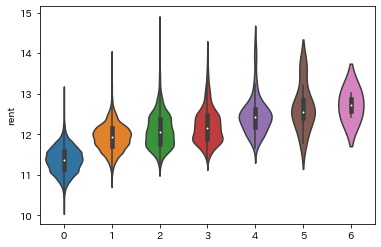

In [34]:
sns.violinplot(train_processed["num_room"] * train_processed["is_L"], target_log)

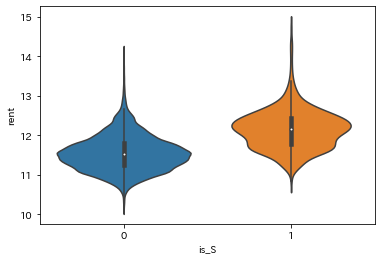

In [33]:
sns.violinplot(train_processed["is_S"], target_log)

In [32]:
train_processed["layout"].value_counts()

1K            11930
1R             5082
1LDK           4823
2LDK           2552
2DK            1909
1DK            1892
3LDK           1124
2K              920
3DK             419
1LDK+S(納戸)      238
2LDK+S(納戸)      157
4LDK            124
1K+S(納戸)         75
3LDK+S(納戸)       68
3K               48
2DK+S(納戸)        25
4DK              16
5LDK             15
1DK+S(納戸)        14
4LDK+S(納戸)       12
3DK+S(納戸)         6
5DK               4
4K                4
5LDK+S(納戸)        4
6LDK              2
1LK+S(納戸)         2
5DK+S(納戸)         1
2K+S(納戸)          1
5K                1
3K+S(納戸)          1
Name: layout, dtype: int64

In [21]:
train_processed.columns.values

array(['location', 'access', 'layout', 'age', 'direction', 'area',
       'floor', 'bath_toilet', 'kitchen', 'broad_com', 'facility',
       'parking', 'environment', 'structure', 'contract_period',
       'district', 'access_line', 'access_sta', 'access_min', '/有楽町線',
       '/浅草線', 'JR中央線', 'JR京浜東北線', 'JR京葉線', 'JR埼京線', 'JR山手線', 'JR常磐線',
       'つくばエクスプレス', 'りんかい線', 'メトロ副都心線', '三田線', '中央本線', '中央総武緩行線', '中央線',
       '丸の内方南支線', '丸の内線', '丸ノ内方南支線', '丸ノ内線', '井の頭線', '京急大師線', '京急本線',
       '京急空港線', '京成成田空港線', '京成押上線', '京成本線', '京成金町線', '京成電鉄本線', '京浜急行線',
       '京浜東北根岸線', '京浜東北線', '京王、小田急線', '京王井の頭線', '京王新線', '京王線', '京王電鉄井の頭線',
       '京王電鉄京王線', '京葉線', '副都心線', '北総線', '北陸新幹線', '千代田線', '半蔵門線', '南北線',
       '南武線', '地下鉄浅草線', '埼京線', '埼玉高速鉄道線', '大江戸線', '小田急小田原線', '小田急線',
       '小田急電鉄小田原線', '山手線', '常磐線', '日暮里舎人ライナー', '日比谷線', '有楽町線',
       '東京メトロ丸の内線', '東京メトロ丸ノ内方南支線', '東京メトロ丸ノ内線', '東京メトロ副都心線', '東京メトロ千代田線',
       '東京メトロ半蔵門線', '東京メトロ南北線', '東京メトロ日比谷線', '東京メトロ有楽町線', '東京メトロ東西線',
       '東京メトロ銀座線', '

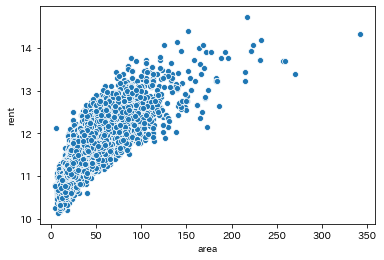

In [22]:
sns.scatterplot(train_processed["area"], target_log)

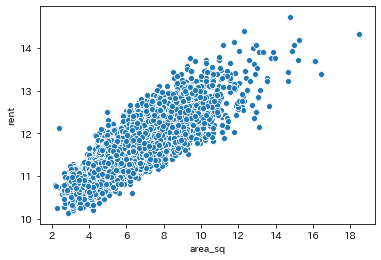

In [25]:
train_processed["area_sq"] = np.sqrt(train_processed["area"])
sns.scatterplot(train_processed["area_sq"], target_log)

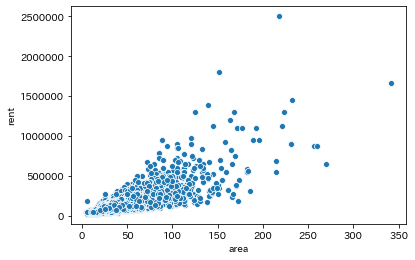

In [23]:
sns.scatterplot(train_processed["area"], target)

In [15]:
env_cols = ["デパート", "公園",
             "郵便局", "コインパーキング", "学校", "train_processed[env_cols][train_processed[env_cols]>0].min(axis=1)図書館", "飲食店", "月極駐車場", "銀行", "小学校",
             "ドラッグストア", "レンタルビデオ", "病院", "総合病院", "コンビニ", "大学", "幼稚園・保育園",
            "スーパー", "クリーニング"]

In [19]:
train_processed[env_cols][train_processed[env_cols]>0].mean(axis=1)

0         692.250000
1        1283.000000
2         136.500000
3         276.500000
4         272.000000
5         313.500000
6         480.500000
7         339.000000
8                NaN
9                NaN
10        366.000000
11               NaN
12               NaN
13               NaN
14        765.750000
15        318.000000
16        326.375000
17        609.428571
18        799.750000
19        158.000000
20        643.500000
21        661.833333
22               NaN
23        322.000000
24               NaN
25        465.000000
26        373.000000
27        383.400000
28        212.000000
29        321.000000
30        205.000000
31               NaN
32        180.000000
33        445.000000
34        736.500000
35        140.000000
36        680.666667
37        219.500000
38         80.000000
39       1054.714286
40               NaN
41        268.500000
42        292.428571
43               NaN
44        570.000000
45        259.000000
46         68.666667
47           

In [17]:
train_processed[env_cols][train_processed[env_cols]>0].min(axis=1)

0         311.0
1        1283.0
2          89.0
3         225.0
4         193.0
5         251.0
6         149.0
7         334.0
8           NaN
9           NaN
10        326.0
11          NaN
12          NaN
13          NaN
14        612.0
15        318.0
16        119.0
17         46.0
18        228.0
19         79.0
20        179.0
21        341.0
22          NaN
23        219.0
24          NaN
25        373.0
26        124.0
27        149.0
28        131.0
29         87.0
30        110.0
31          NaN
32        180.0
33        328.0
34        669.0
35        140.0
36        600.0
37        106.0
38         80.0
39        641.0
40          NaN
41        221.0
42         66.0
43          NaN
44        500.0
45        165.0
46         21.0
47          NaN
48        103.0
49        125.0
50        120.0
51        259.0
52          NaN
53        228.0
54        390.0
55        101.0
56          NaN
57        130.0
58         52.0
59        177.0
60        465.0
61          NaN
62      

In [14]:
#test_processed["area"] = test_processed["area"].str[:-2].astype(float)
train_processed.groupby("district")["bicycle_parking"].mean()

district
世田谷    0.628861
中央     0.864957
中野     0.704523
北      0.317647
千代田    0.804147
台東     0.723329
品川     0.688377
墨田     0.567568
大田     0.702830
文京     0.610843
新宿     0.703244
杉並     0.592773
板橋     0.509861
江戸川    0.675018
江東     0.736916
渋谷     0.602273
港      0.739855
目黒     0.608571
練馬     0.705174
荒川     0.475191
葛飾     0.421776
豊島     0.473033
足立     0.550468
Name: bicycle_parking, dtype: float64

In [106]:
#train_processed["target"] = target_log
tmp = train_processed["district"].to_frame()
tmp["target"] = target_log
tmp.head()

,district,target
0,北,11.225257
1,中央,11.238502
2,渋谷,11.608245
3,杉並,11.918397
4,葛飾,11.211834


In [97]:
te = tmp.groupby("district")["target"].mean()

In [99]:
te.keys()

Index(['世田谷', '中央', '中野', '北', '千代田', '台東', '品川', '墨田', '大田', '文京', '新宿', '杉並',
       '板橋', '江戸川', '江東', '渋谷', '港', '目黒', '練馬', '荒川', '葛飾', '豊島', '足立'],
      dtype='object', name='district')

In [103]:
tmp["te"] = tmp["district"].map(te)

/Users/kohei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
tmp.head()

,district,target,te
0,北,11.225257,11.425095
1,中央,11.238502,12.030486
2,渋谷,11.608245,11.889517
3,杉並,11.918397,11.401813
4,葛飾,11.211834,11.227584


In [77]:
geo_train = pd.DataFrame()

In [81]:
geo_train["名前"] = 0

In [79]:
geo_train["住所"] = train_processed["location"]

In [82]:
geo_train.head()

,名前,住所
0,0,東京都北区滝野川３丁目
1,0,東京都中央区月島３丁目
2,0,東京都渋谷区笹塚２丁目
3,0,東京都杉並区高円寺南２丁目23-2
4,0,東京都葛飾区金町３丁目7-2


In [84]:
geo_train["緯度"] = 0

In [85]:
geo_train["経度"] = 0

In [88]:
geo_train.to_csv("/Users/kohei/Desktop/geo_train.csv", index=None)

In [6]:
train_cols_eng = ["id", "rent", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]
test_cols_eng = ["id", "location", "access", "layout", "age", "direction", "area", "floor",
           "bath_toilet", "kitchen", "broad_com", "facility", "parking", "environment", "structure",
           "contract_period"]

train = pd.read_csv("../data/train.csv", names=train_cols_eng, header=0)
test = pd.read_csv("../data/test.csv", names=test_cols_eng, header=0)

use_cols = []

In [4]:
train["area"] = train["area"].str[:-2].astype(float)
train.groupby("district")["area"].mean()

KeyError: 'district'

In [52]:
train.isnull().sum()

id                    0
rent                  0
location              0
access                0
layout                0
age                   0
direction          2749
area                  0
floor                 0
bath_toilet         329
kitchen             621
broad_com          3440
facility             82
parking            5287
environment        9432
structure             0
contract_period    7120
district              0
access_line           0
access_sta            0
access_min            0
dtype: int64

In [3]:
train_processed = preprocess_df(train)
test_processed = preprocess_df(test)

In [4]:
train_processed.shape, test_processed.shape

((31470, 768), (31262, 778))

In [7]:
train_cols = train_processed.columns.values
test_cols = test_processed.columns.values

In [9]:
[col for col in test_cols if col not in train_cols]

['/東京メトロ丸の内線',
 '。日比谷線',
 '中央総武線',
 '大井町線',
 '新京成線',
 '東京都副都心線',
 '東京都千代田線',
 '東京都南北線',
 '東京都浅草線',
 '浅草線',
 '西部有楽町線',
 'ＪＲ総武線',
 '.雑司が谷駅',
 'みずほ台駅',
 '京浜蒲田駅',
 '千鳥駅',
 '東好悪駅',
 '東門前駅',
 '桜上上水駅',
 '武蔵小杉駅',
 '浦和駅',
 '西部新宿駅',
 '鈴木町駅',
 '高津駅',
 '鶴瀬駅',
 '鹿島田駅',
 'トイレなし']

In [62]:
train_processed.head(2)

,location,access,layout,age,direction,area,floor,bath_toilet,kitchen,broad_com,facility,parking,environment,structure,contract_period,district,access_line,access_sta,access_min,/有楽町線,/浅草線,JR中央線,JR京浜東北線,JR京葉線,JR埼京線,JR山手線,JR常磐線,つくばエクスプレス,りんかい線,メトロ副都心線,三田線,中央本線,中央総武緩行線,中央線,丸の内方南支線,丸の内線,丸ノ内方南支線,丸ノ内線,井の頭線,京急大師線,京急本線,京急空港線,京成成田空港線,京成押上線,京成本線,京成金町線,京成電鉄本線,京浜急行線,京浜東北根岸線,京浜東北線,京王、小田急線,京王井の頭線,京王新線,京王線,京王電鉄井の頭線,京王電鉄京王線,京葉線,副都心線,北総線,北陸新幹線,千代田線,半蔵門線,南北線,南武線,地下鉄浅草線,埼京線,埼玉高速鉄道線,大江戸線,小田急小田原線,小田急線,小田急電鉄小田原線,山手線,常磐線,日暮里舎人ライナー,日比谷線,有楽町線,東京メトロ丸の内線,東京メトロ丸ノ内方南支線,東京メトロ丸ノ内線,東京メトロ副都心線,東京メトロ千代田線,東京メトロ半蔵門線,東京メトロ南北線,東京メトロ日比谷線,東京メトロ有楽町線,東京メトロ東西線,東京メトロ銀座線,東京モノレール羽田線,東京都京浜東北線,東京都埼京線,東京都山手線,東京都有楽町線,東京都東武東上線,東京都都営三田線,東京都都電荒川線,東北新幹線,東北本線,東急世田谷線,東急多摩川線,東急大井町線,東急東横線,東急池上線,東急田園都市線,東急目黒線,東武スカイツリーライン,東武亀戸線,東武伊勢崎大師線,東武伊勢崎線,東武大師線,東武東上線,東海道新幹線,東海道本線,東西線,横須賀線,湘南新宿ライン,総武本線,総武線,荒川線,西武新宿線,西武有楽町線,西武池袋線,西武池袋豊島線,西武豊島線,都営三田線,都営大江戸線,都営新宿線,都営浅草線,都電荒川線,銀座線,高崎線,ＪＲ中央線,ＪＲ山手線,お花茶屋駅,つつじケ丘駅,とうきょうスカイツリー駅,ときわ台駅,ひばりケ丘駅,一之江駅,三ノ輪橋駅,三ノ輪駅,三河島駅,三田駅,三越前駅,三軒茶屋駅,三鷹台駅,三鷹駅,上中里駅,上井草駅,上北沢駅,上板橋駅,...,霞ケ関駅,青井駅,青山一丁目駅,青物横丁駅,青砥駅,面影橋駅,飛鳥山駅,飯田橋駅,馬喰横山駅,馬喰町駅,馬込駅,駒場東大前駅,駒沢大学駅,駒込駅,高井戸駅,高円寺駅,高島平駅,高田馬場駅,高輪台駅,高野駅,鬼子母神前駅,鮫洲駅,鵜の木駅,鶯谷駅,鷺ノ宮駅,麹町駅,麻布十番駅,is_K,is_R,is_L,is_D,is_S,num_room,age_year,age_month,age_in_months,has_N,has_S,has_E,has_W,building_floor,room_floor,has_underground,シャワー,バスなし,バス・トイレ別,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能,IHコンロ,L字キッチン,カウンターキッチン,ガスコンロ,コンロ1口,コンロ2口,コンロ3口,コンロ4口以上,コンロ設置可（コンロ1口）,コンロ設置可（コンロ2口）,コンロ設置可（コンロ3口）,コンロ設置可（コンロ4口以上）,コンロ設置可（口数不明）,システムキッチン,冷蔵庫あり,独立キッチン,給湯,電気コンロ,BSアンテナ,CATV,CSアンテナ,インターネット使用料無料,インターネット対応,光ファイバー,有線放送,高速インターネット,24時間換気システム,2面採光,3面採光,ウォークインクローゼット,エアコン付,エレベーター,オール電化,ガスその他,ガス暖房,クッションフロア,シューズボックス,タイル張り,トランクルーム,バリアフリー,バルコニー,フローリング,プロパンガス,ペアガラス,ルーフバルコニー,ロフト付き,下水,二世帯住宅,二重サッシ,井戸,公営水道,冷房,出窓,地下室,室内洗濯機置場,室外洗濯機置場,専用庭,床下収納,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,bicycle_parking,car_parking,bike_parking,environment_list,デパート,公園,郵便局,コインパーキング,学校,図書館,飲食店,月極駐車場,銀行,小学校,ドラッグストア,レンタルビデオ,病院,総合病院,コンビニ,大学,幼稚園・保育園,スーパー,クリーニング,fixed_term,contract_period_year,contract_period_month,contract_period_in_months
0,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス\tバルコニー\tフローリング\t室内洗濯機置場\t敷地内ごみ...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間,北,"[都営三田線, 埼京線, 都電荒川線]","[西巣鴨駅, 板橋駅, 西ケ原四丁目駅]","[4, 14, 7]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,9,9,117,0,1,1,0,12.0,1.0,0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,"[小学校, 大学, 小学校, 公園, 飲食店, スーパー, コンビニ, スーパー, ドラッグ...",0.0,1103.0,1246.0,0.0,0.0,0.0,378.0,0.0,0.0,495.0,956.0,0.0,0.0,0.0,588.0,461.0,0.0,311.0,0.0,0.0,2.0,0.0,24.0
1,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,方向なし,16.50,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン／\t給湯,インターネット対応,エアコン付\tシューズボックス\tバルコニー\tフローリング\t室内洗濯機置場\t敷地内ごみ...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間,中央,"[都営大江戸線, 有楽町線, 日比谷線]","[勝どき駅, 月島駅, 築地駅]","[5, 9, 20]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [61]:
env_cols = ["デパート", "公園",
             "郵便局", "コインパーキング", "学校", "図書館", "飲食店", "月極駐車場", "銀行", "小学校",
             "ドラッグストア", "レンタルビデオ", "病院", "総合病院", "コンビニ", "大学", "幼稚園・保育園",
            "スーパー", "クリーニング"]

(train_processed[env_cols] != 0).sum(axis=1)

0         8
1         1
2         2
3         2
4         2
5         2
6         2
7         2
8        19
9        19
10        2
11       19
12       19
13       19
14        4
15        1
16        8
17        7
18        4
19        2
20        6
21        6
22       19
23        2
24       19
25        5
26        3
27        5
28        3
29        2
30        4
31       19
32        1
33        2
34        2
35        1
36        3
37        2
38        2
39        7
40       19
41        2
42        7
43       19
44        2
45        2
46        3
47       19
48        4
49        2
50        2
51        2
52       19
53        3
54        5
55        1
56       19
57        3
58        5
59        3
60        4
61       19
62       19
63        5
64        1
65        2
66        3
67        5
68        1
69       19
70        3
71        3
72       19
73        7
74       19
75        3
76       19
77       19
78        4
79       19
80       19
81        2
82        2
83  

In [53]:
`train_processed["location"].head().values

array(['東京都北区滝野川３丁目', '東京都中央区月島３丁目', '東京都渋谷区笹塚２丁目', '東京都杉並区高円寺南２丁目23-2',
       '東京都葛飾区金町３丁目7-2'], dtype=object)

In [44]:
import geocoder

In [51]:
#import geocoder
g = geocoder.google('甲子園')
print(g.)

None


In [42]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm


URL = 'http://www.geocoding.jp/api/'


def coordinate(address):
    """
    addressに住所を指定すると緯度経度を返す。

    >>> coordinate('東京都文京区本郷7-3-1')
    ['35.712056', '139.762775']
    """
    payload = {'q': address}
    html = requests.get(URL, params=payload)
    soup = BeautifulSoup(html.content, "html.parser")
    if soup.find('error'):
        print(f"Invalid address submitted. {address}")
        return np.nan
    latitude = soup.find('lat').string
    longitude = soup.find('lng').string
    return [latitude, longitude]


def coordinates(addresses, interval=0.1):
    """
    addressesに住所リストを指定すると、緯度経度リストを返す。

    >>> coordinates(['東京都文京区本郷7-3-1', '東京都文京区湯島３丁目３０−１'], progress=False)
    [['35.712056', '139.762775'], ['35.707771', '139.768205']]
    """
    coordinates = []
    for address in tqdm(addresses):
        coordinates.append(coordinate(address))
        time.sleep(interval)
    return coordinates

In [43]:
coordinates = coordinates(list(train_processed["location"].values))


  0%|          | 3/31469 [00:03<9:47:29,  1.12s/it]

Invalid address submitted. 東京都渋谷区笹塚２丁目



  0%|          | 5/31469 [00:05<9:38:39,  1.10s/it]

KeyboardInterrupt: 

In [20]:
train_processed.drop(20427, axis=0, inplace=True) # 築1019年、どう修正するべきか不明なので
train_processed.loc[20231, "age_year"] = 52
train_processed.loc[20231, "age_in_months"] = 52 * 12 + 5 # 築520年、おそらく52年のタイポと仮定

train_processed.loc[5775, "rent"] = 120350 # 条件からしてありえない高値。おそらくゼロの個数違い
train_processed.loc[20926, "rent"] = 1160000 # 条件からしてありえない安値。おそらくゼロの個数違い

train_processed.reset_index(drop=True, inplace=True)
target = train_processed["rent"]
target_log = np.log1p(target)
train_processed.drop(["id", "rent"], axis=1, inplace=True)
test_processed.drop("id", axis=1, inplace=True)

In [29]:
if []:
    print("fdf")

In [21]:
train_cols = train_processed.columns.values
test_cols = test_processed.columns.values

In [24]:
train_processed["access_sta"].head()

0    [西巣鴨駅, 板橋駅, 西ケ原四丁目駅]
1        [勝どき駅, 月島駅, 築地駅]
2       [笹塚駅, 代田橋駅, 明大前駅]
3          [新高円寺駅, 東高円寺駅]
4       [京成金町駅, 金町駅, 柴又駅]
Name: access_sta, dtype: object

In [22]:
train_cols

array(['location', 'access', 'layout', 'age', 'direction', 'area',
       'floor', 'bath_toilet', 'kitchen', 'broad_com', 'facility',
       'parking', 'environment', 'structure', 'contract_period',
       'district', 'access_line', 'access_sta', 'access_min', '/有楽町線',
       '/浅草線', 'JR中央線', 'JR京浜東北線', 'JR京葉線', 'JR埼京線', 'JR山手線', 'JR常磐線',
       'つくばエクスプレス', 'りんかい線', 'メトロ副都心線', '三田線', '中央本線', '中央総武緩行線', '中央線',
       '丸の内方南支線', '丸の内線', '丸ノ内方南支線', '丸ノ内線', '井の頭線', '京急大師線', '京急本線',
       '京急空港線', '京成成田空港線', '京成押上線', '京成本線', '京成金町線', '京成電鉄本線', '京浜急行線',
       '京浜東北根岸線', '京浜東北線', '京王、小田急線', '京王井の頭線', '京王新線', '京王線', '京王電鉄井の頭線',
       '京王電鉄京王線', '京葉線', '副都心線', '北総線', '北陸新幹線', '千代田線', '半蔵門線', '南北線',
       '南武線', '地下鉄浅草線', '埼京線', '埼玉高速鉄道線', '大江戸線', '小田急小田原線', '小田急線',
       '小田急電鉄小田原線', '山手線', '常磐線', '日暮里舎人ライナー', '日比谷線', '有楽町線',
       '東京メトロ丸の内線', '東京メトロ丸ノ内方南支線', '東京メトロ丸ノ内線', '東京メトロ副都心線', '東京メトロ千代田線',
       '東京メトロ半蔵門線', '東京メトロ南北線', '東京メトロ日比谷線', '東京メトロ有楽町線', '東京メトロ東西線',
       '東京メトロ銀座線', '